In [2]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
from pyspark.ml.stat import Correlation

import numpy as np

## Some functions

This is code taken from the matplotlib example on creating heatmaps.

In [3]:
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Initialize variables and download from server

In [4]:
hdfs_port = "hdfs://orion11:26990"
# data_path = "/nam_s/nam_201501_s*"
data_path = "/nam_s/*"
# data_path = "/sample/nam_tiny*"

In [5]:
feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    line = line.strip()
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line, LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line, StringType(), True))
    else:
        # Other features
        feats.append(StructField(line, FloatType(), True))
        
    
schema = StructType(feats)

## Run the query

We obtain column names and create the correlation matrix. Then we use the column names as part of a Pandas data frame

In [6]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load(f'{hdfs_port}{data_path}')
df = df.drop('Timestamp').drop('Geohash')
col_names = df.columns

AnalysisException: 'java.lang.RuntimeException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient;'

In [1]:
%%time

from pyspark.mllib.stat import Statistics
import pandas as pd

df.sample(False, 0.1)

features = df.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

NameError: name 'df' is not defined

## Plotting the large matrix

We can see that only a few squares have a high correlation. 

/home4/mcdomingo/.conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


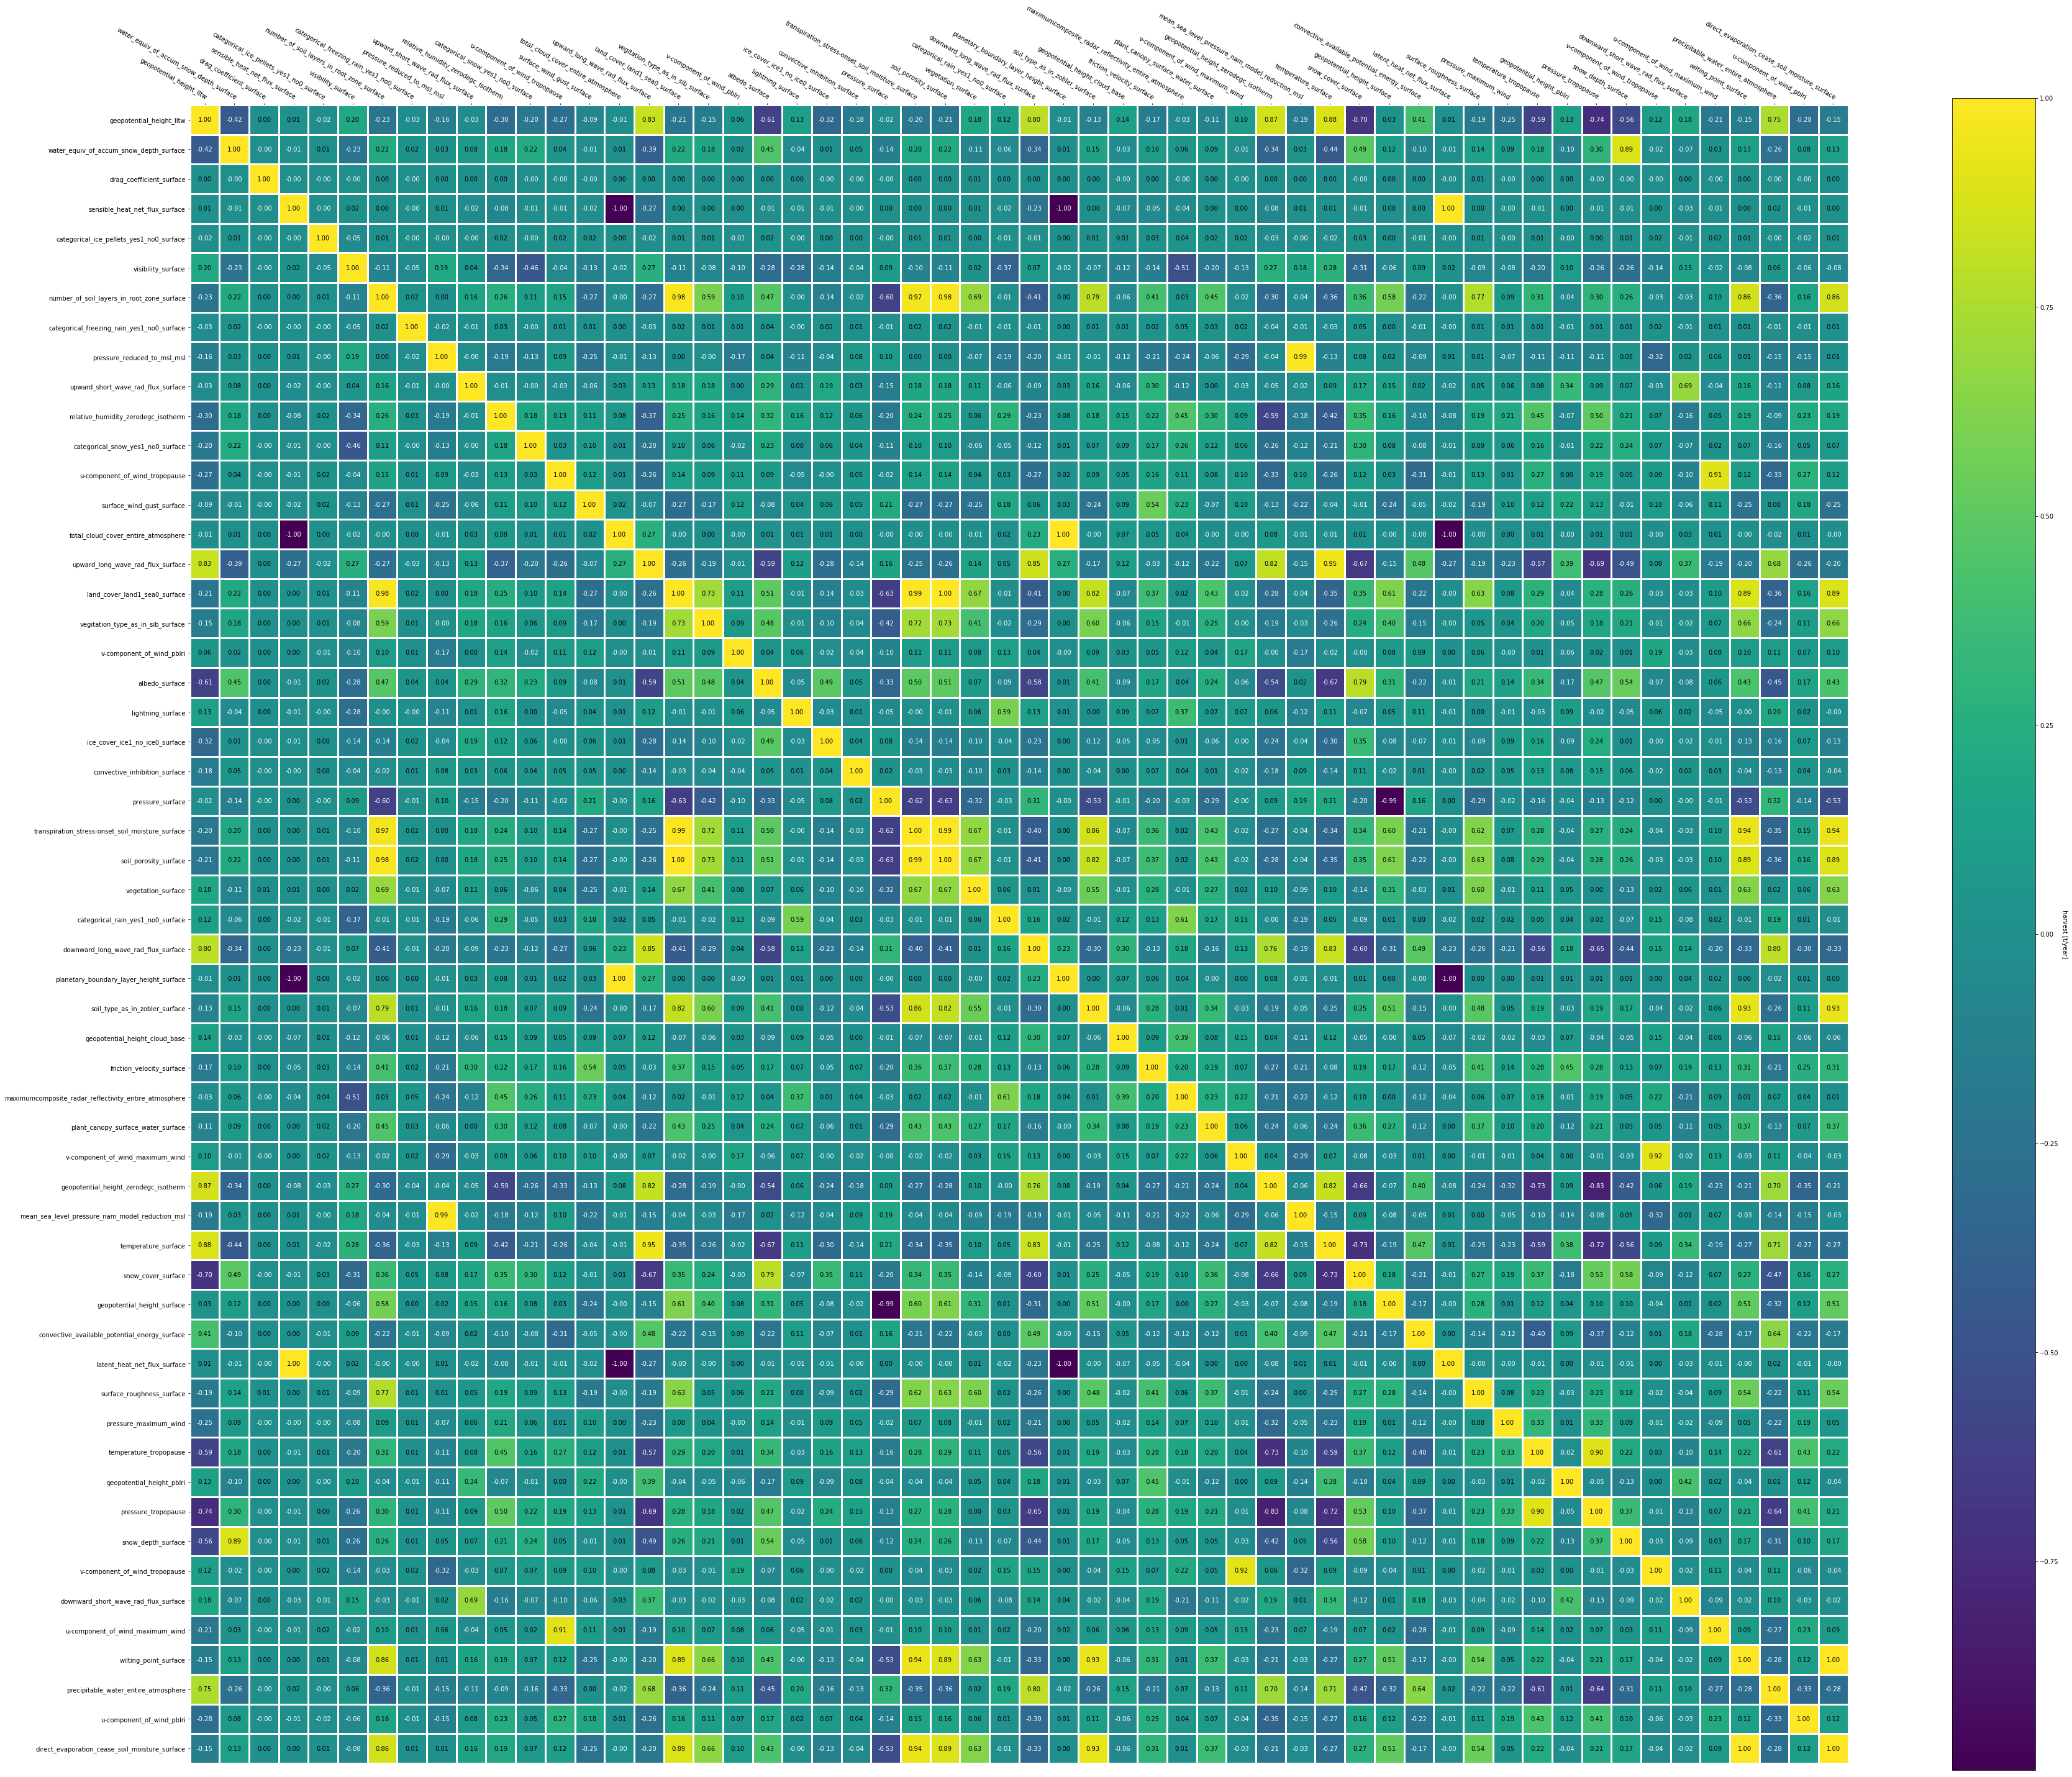

In [50]:
fig, ax = plt.subplots(figsize=(50,40))

im, cbar = heatmap(corr_df, col_names, col_names, ax=ax,
                   cmap="viridis", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=["white", "black"])

fig.tight_layout()
plt.show()

## High correlation only

I'm filtering out everything that has a "low" correlation magnitude. That is, everything not in the range from -0.8 to 0.8.

In [55]:
small_corr_mat = corr_df.copy()
small_corr_mat = small_corr_mat[((small_corr_mat > 0.8) | (small_corr_mat < -0.8)) & (small_corr_mat != 1)].dropna(thresh=1)
rows = set(small_corr_mat.index)
cols = set(small_corr_mat.columns.values)
row_diff = cols.difference(rows)
small_corr_mat = small_corr_mat.drop(list(row_diff), axis = 1)

cols = small_corr_mat.columns.values
rows = small_corr_mat.index.values
print(small_corr_mat.shape)

(29, 29)


##  Analysis
From this we can see that only a small amount of data points have a high correlation. It also appears that most highly correlated groups can be partitioned off into seperate groups. Like wilting_point_surface and direct_evaporation_cease..., soil_type_as_... all have high correlation with one another.

/home4/mcdomingo/.conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


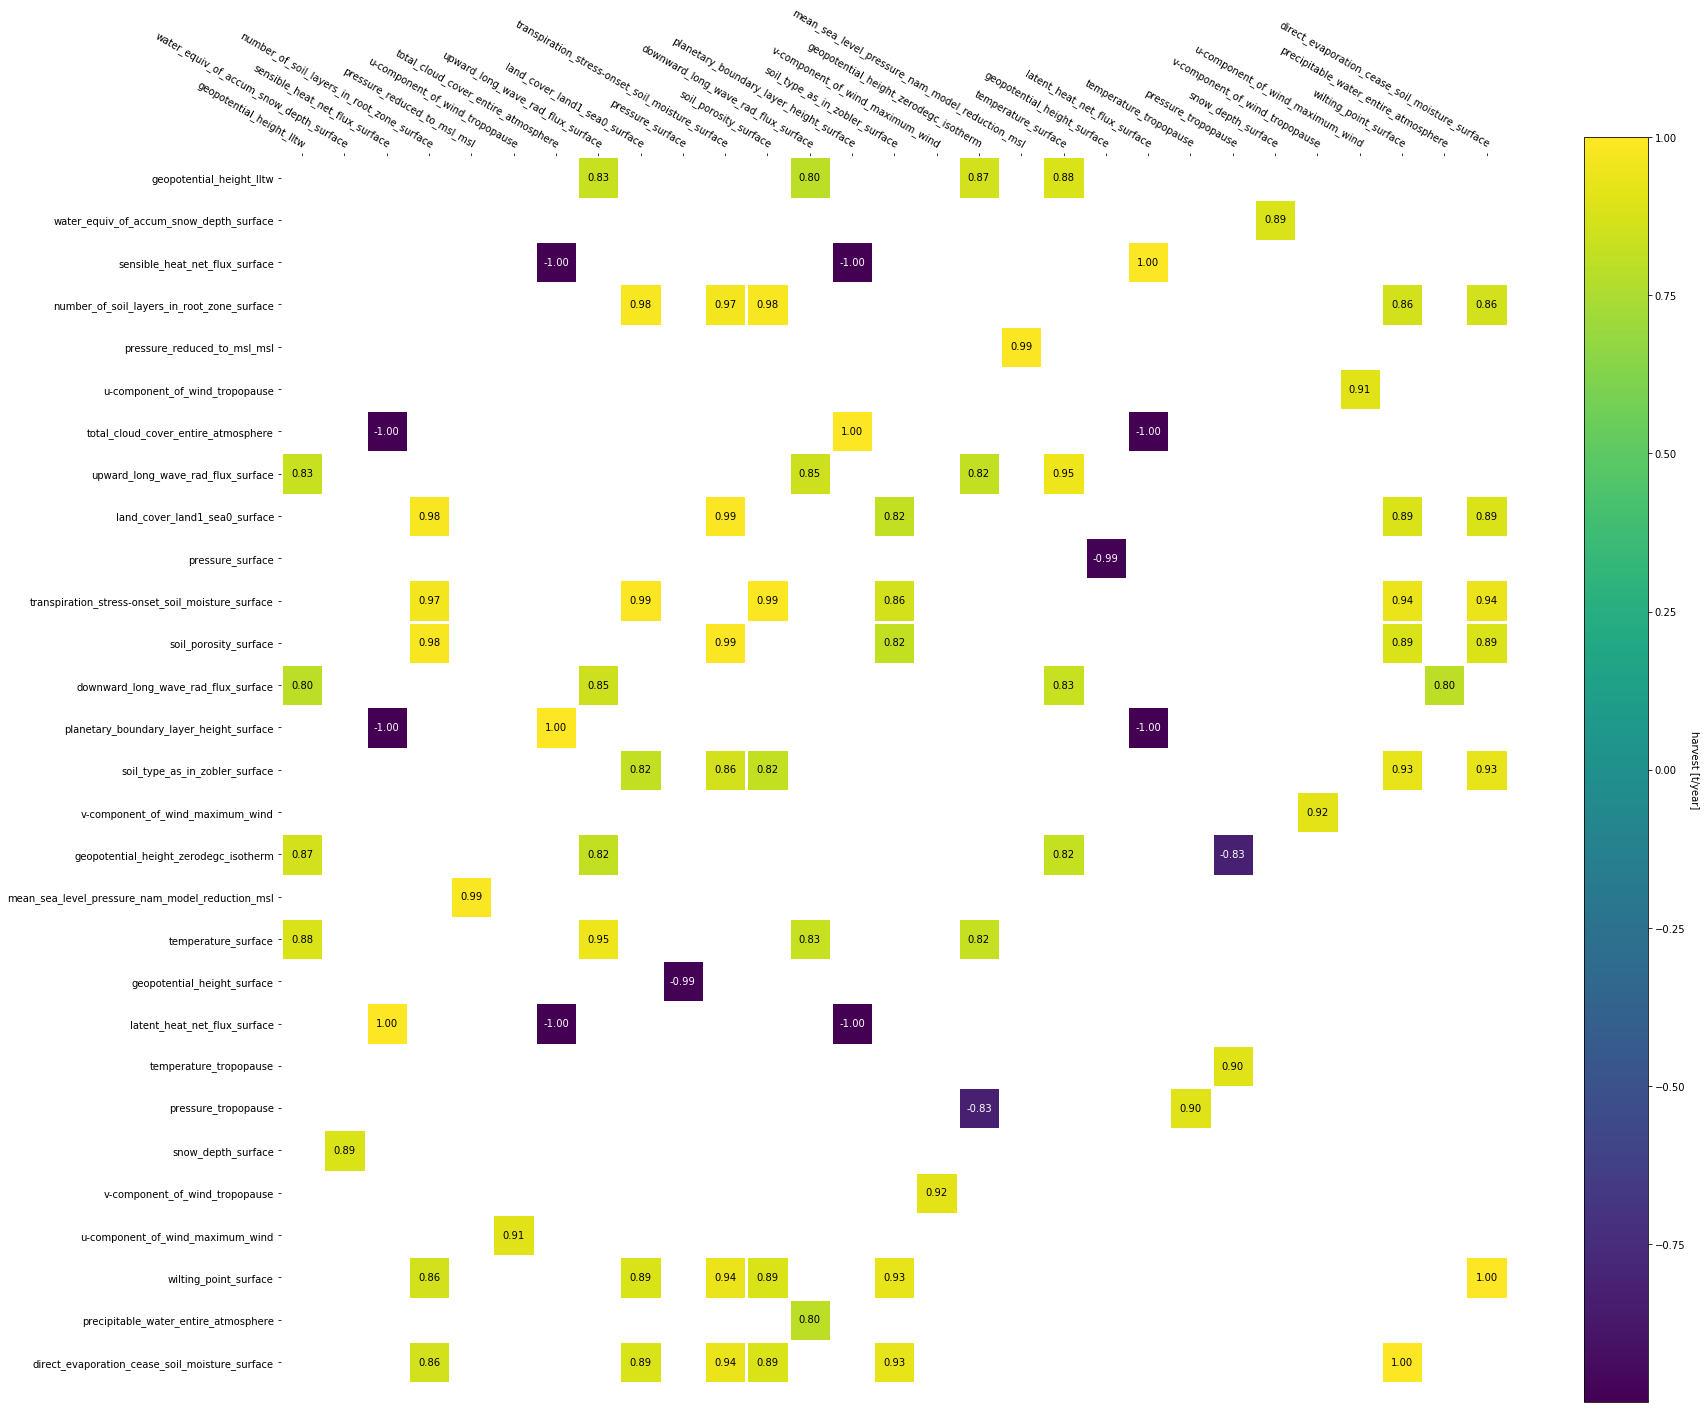

In [58]:
fig, ax = plt.subplots(figsize=(25,20))

im, cbar = heatmap(small_corr_mat, cols, rows, ax=ax,
                   cmap="viridis", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=["white", "black"])

fig.tight_layout()
plt.show()